In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import date
import matplotlib.pyplot as plt
import glob, re

In [13]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,5)

In [14]:
FII_PATH = Path("FiiDiiTradingactivity.csv")
SECTOR_GLOBS = [
    "NIFTY_50.csv",
    "NIFTY_BANK.csv",
    "NIFTY_IT.csv",
    "NIFTY_FMCG.csv",
    "NIFTY_AUTO.csv",
    "NIFTY_PHARMA.csv",
    "NIFTY_METAL.csv",
    "NIFTY_PSU_BANK.csv",
    "NIFTY_REALTY.csv",
    "NIFTY_ENERGY.csv",
    "NIFTY_REALTY.csv"
]

OUT_DIR = Path("")
MASTER_OUT = "master_market_data_2015_2022.csv"
CLEAN_FII_OUT ="FII_DII_cleaned.csv"

print("FII file exists:", FII_PATH.exists())
print("Sector files found:", sum(Path(p).exists() for p in SECTOR_GLOBS))

FII file exists: True
Sector files found: 11


In [18]:
# Cell 2: helper functions for numeric parsing and safe read
def parse_num(x):
    """Convert messy strings like '1,234', '(1,234)', '--' to float or NaN."""
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float, np.integer, np.floating)):
        return float(x)
    s = str(x).strip()
    if s in ["", "-", "--", "NA", "N/A", "na"]:
        return np.nan
    neg = False
    if s.startswith("(") and s.endswith(")"):
        neg = True
        s = s[1:-1]
    s = s.replace(",", "")
    s = re.sub(r"[^\d\.\-eE]", "", s)
    try:
        val = float(s)
        return -val if neg else val
    except:
        return np.nan

def load_index_csv_standard(path):
    """
    Read an index CSV and return DataFrame with columns:
    Date (datetime) and Close_Price (float).
    Works for all your CSVs.
    """
    df = pd.read_csv(path, engine='python', on_bad_lines='skip')
    
    # find Date column
    date_col = None
    for c in ["Date","date","DATE","Trading Date"]:
        if c in df.columns:
            date_col = c
            break
    if date_col is None:
        date_col = df.columns[0]

    df = df.rename(columns={date_col: "Date"})

    # find Close column
    close_col = None
    for c in ["Close", "Adj Close", "Close_Price", "Close Price", "ClosePrice"]:
        if c in df.columns:
            close_col = c
            break

    if close_col is None:
        for c in df.columns:
            if "close" in c.lower():
                close_col = c
                break

    if close_col is None:
        raise ValueError(f"No close column found in {path}, columns={df.columns.tolist()}")

    # Keep only Date + Close
    df = df[["Date", close_col]].rename(columns={close_col: "Close_Price"})

    # Clean
    df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
    df = df.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)
    df["Close_Price"] = df["Close_Price"].apply(parse_num)

    return df



In [16]:
# Cell 3: load and clean FII/DII
print("Loading FII/DII from:", FII_PATH)
# prefer engine='python' for messy files
fii_raw = pd.read_csv(FII_PATH, engine='python')

print("Raw columns:", list(fii_raw.columns)[:50])
display(fii_raw.head(5))

# find date column
date_col = None
for c in fii_raw.columns:
    if "date" in c.lower():
        date_col = c
        break
if date_col is None:
    date_col = fii_raw.columns[0]
fii_raw = fii_raw.rename(columns={date_col: "Date"})
fii_raw["Date"] = pd.to_datetime(fii_raw["Date"], dayfirst=True, errors='coerce')
print("Date range after parse:", fii_raw["Date"].min(), "to", fii_raw["Date"].max())

# parse numeric columns: create parsed versions for every non-date column
for c in fii_raw.columns:
    if c == "Date":
        continue
    parsed_col = c.strip() + "_num"
    fii_raw[parsed_col] = fii_raw[c].apply(parse_num)

# collapse parsed numeric columns into cleaned df
parsed_cols = [c for c in fii_raw.columns if c.endswith("_num")]
clean = fii_raw[["Date"] + parsed_cols].copy()
# rename parsed columns heuristically to canonical names
rename_map = {}
for c in parsed_cols:
    orig = c[:-4].lower()
    if "fii" in orig and "buy" in orig:
        rename_map[c] = "FII_Buy"
    elif "fii" in orig and "sell" in orig:
        rename_map[c] = "FII_Sell"
    elif ("fii" in orig or "fpi" in orig) and "net" in orig:
        rename_map[c] = "FII_Net"
    elif "dii" in orig and "buy" in orig:
        rename_map[c] = "DII_Buy"
    elif "dii" in orig and "sell" in orig:
        rename_map[c] = "DII_Sell"
    elif "dii" in orig and "net" in orig:
        rename_map[c] = "DII_Net"
    else:
        # fallback: keep original (cleaned) name
        rename_map[c] = orig.replace(" ", "_")

clean = clean.rename(columns=rename_map)
# keep only relevant canonical columns
keep = ["Date"] + [c for c in ["FII_Buy","FII_Sell","FII_Net","DII_Buy","DII_Sell","DII_Net"] if c in clean.columns]
fii_clean = clean[keep].copy()

# if nets missing but buy/sell exist, compute them
if "FII_Net" not in fii_clean.columns and {"FII_Buy","FII_Sell"}.issubset(fii_clean.columns):
    fii_clean["FII_Net"] = fii_clean["FII_Buy"] - fii_clean["FII_Sell"]
if "DII_Net" not in fii_clean.columns and {"DII_Buy","DII_Sell"}.issubset(fii_clean.columns):
    fii_clean["DII_Net"] = fii_clean["DII_Buy"] - fii_clean["DII_Sell"]

print("Cleaned FII/DII columns:", list(fii_clean.columns))
display(fii_clean.head(5))
fii_clean.to_csv(CLEAN_FII_OUT, index=False)
print("Saved cleaned FII/DII to:", CLEAN_FII_OUT)


Loading FII/DII from: FiiDiiTradingactivity.csv
Raw columns: ['Date', 'FII_Gross_Purchase', 'FII_Gross_Sales', 'FII_Net_Purchase/Sales', 'DII_Gross_Purchase', 'DII_Gross_Sales', 'DII_Net_Purchase/Sales']


,Date,FII_Gross_Purchase,FII_Gross_Sales,FII_Net_Purchase/Sales,DII_Gross_Purchase,DII_Gross_Sales,DII_Net_Purchase/Sales
0,01-01-2008,888.69,1350.10,-461.41,1284.38,977.44,306.94
1,01-01-2009,260.28,168.24,92.04,598.23,437.82,160.41
2,01-01-2013,885.51,220.46,665.05,857.63,1263.77,-406.14
3,01-01-2014,225.12,214.96,10.16,359.22,581.34,-222.12
4,01-01-2015,248.38,230.18,18.20,691.07,671.51,19.56


Date range after parse: 2007-01-06 00:00:00 to 2022-12-08 00:00:00
Cleaned FII/DII columns: ['Date', 'FII_Net', 'DII_Net']


,Date,FII_Net,DII_Net
0,2008-01-01,-461.41,306.94
1,2009-01-01,92.04,160.41
2,2013-01-01,665.05,-406.14
3,2014-01-01,10.16,-222.12
4,2015-01-01,18.20,19.56


Saved cleaned FII/DII to: FII_DII_cleaned.csv


In [19]:
# Cell 4: load all sector CSVs present in SECTOR_GLOBS
sector_dfs = {}
for path in SECTOR_GLOBS:
    p = Path(path)
    if not p.exists():
        print("Missing:", p)
        continue
    try:
        df = load_index_csv_standard(p)
        name = p.stem.upper().replace(" ", "_")
        sector_dfs[name] = df.rename(columns={"Close_Price": f"{name}_Close"})
        print(f"Loaded {name}: rows={len(df)} range={df['Date'].min().date()} to {df['Date'].max().date()}")
    except Exception as e:
        print("Failed to load", p.name, ":", e)

if not sector_dfs:
    raise RuntimeError("No sector files loaded. Check SECTOR_GLOBS paths.")


Loaded NIFTY_50: rows=2678 range=2015-01-02 to 2025-11-18
Loaded NIFTY_BANK: rows=2402 range=2015-01-02 to 2025-11-18
Loaded NIFTY_IT: rows=2387 range=2015-01-02 to 2025-11-18
Loaded NIFTY_FMCG: rows=2668 range=2015-01-01 to 2025-11-18
Loaded NIFTY_AUTO: rows=2669 range=2015-01-01 to 2025-11-18
Loaded NIFTY_PHARMA: rows=2683 range=2015-01-01 to 2025-11-18
Loaded NIFTY_METAL: rows=2669 range=2015-01-01 to 2025-11-18
Loaded NIFTY_PSU_BANK: rows=2669 range=2015-01-01 to 2025-11-18
Loaded NIFTY_REALTY: rows=2669 range=2015-01-01 to 2025-11-18
Loaded NIFTY_ENERGY: rows=2669 range=2015-01-01 to 2025-11-18
Loaded NIFTY_REALTY: rows=2669 range=2015-01-01 to 2025-11-18


In [20]:
# Cell 5: merge into master table (use NIFTY_50 as reference)
ref = None
for k in sector_dfs:
    if "NIFTY_50" in k:
        ref = k
        break
if not ref:
    ref = list(sector_dfs.keys())[0]

master = sector_dfs[ref][["Date", f"{ref}_Close"]].rename(columns={f"{ref}_Close": "NIFTY_50_Close"})
for name, df in sector_dfs.items():
    if name == ref:
        continue
    master = master.merge(df, on="Date", how="left")

# merge FII/DII cleaned
master = master.merge(fii_clean, on="Date", how="left")
master = master.sort_values("Date").reset_index(drop=True)
print("Master shape:", master.shape)
print("Date range:", master['Date'].min(), "to", master['Date'].max())
display(master.head(5))


Master shape: (2678, 13)
Date range: 2015-01-02 00:00:00 to 2025-11-18 00:00:00


,Date,NIFTY_50_Close,NIFTY_BANK_Close,NIFTY_IT_Close,NIFTY_FMCG_Close,NIFTY_AUTO_Close,NIFTY_PHARMA_Close,NIFTY_METAL_Close,NIFTY_PSU_BANK_Close,NIFTY_REALTY_Close,NIFTY_ENERGY_Close,FII_Net,DII_Net
0,2015-01-02,8395.450195,19057.580078,11372.099609,20142.650391,8365.400391,10955.599609,2715.449951,4311.649902,205.100006,8668.650391,NaN,NaN
1,2015-01-05,8378.400391,19017.179688,11248.549805,20184.849609,8467.950195,10920.599609,2704.500000,4281.149902,205.250000,8651.500000,NaN,NaN
2,2015-01-06,8127.350098,18430.535156,10959.900391,19863.349609,8248.200195,10637.799805,2610.449951,4104.600098,198.050003,8304.000000,113.47,49.34
3,2015-01-07,8102.100098,18304.037109,10916.000000,19841.099609,8254.700195,10604.950195,2568.649902,4091.600098,197.399994,8404.900391,75.03,52.12
4,2015-01-08,8234.599609,18701.183594,11018.150391,20244.150391,8397.299805,10737.599609,2609.250000,4164.750000,203.500000,8450.500000,NaN,NaN


In [21]:
# Cell 6: returns & rolling volatility + sector 30d returns
close_cols = [c for c in master.columns if c.endswith("_Close")]
for c in close_cols:
    ret_col = c.replace("_Close", "_Return")
    master[ret_col] = master[c].pct_change()

# rolling vol for NIFTY_50
master["Vol_7d"] = master["NIFTY_50_Return"].rolling(7, min_periods=3).std()
master["Vol_30d"] = master["NIFTY_50_Return"].rolling(30, min_periods=10).std()
master["Vol_90d"] = master["NIFTY_50_Return"].rolling(90, min_periods=30).std()

# sector momentum (30-day)
for c in close_cols:
    mom_col = c.replace("_Close", "_30dRet")
    master[mom_col] = master[c].pct_change(periods=30)

display(master[['Date','NIFTY_50_Close','NIFTY_50_Return','Vol_30d']].head(10))


C:\Users\tanay\AppData\Local\Temp\ipykernel_17536\1067395171.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  master[ret_col] = master[c].pct_change()
C:\Users\tanay\AppData\Local\Temp\ipykernel_17536\1067395171.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  master[ret_col] = master[c].pct_change()
C:\Users\tanay\AppData\Local\Temp\ipykernel_17536\1067395171.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not 

,Date,NIFTY_50_Close,NIFTY_50_Return,Vol_30d
0,2015-01-02,8395.450195,NaN,NaN
1,2015-01-05,8378.400391,-0.002031,NaN
2,2015-01-06,8127.350098,-0.029964,NaN
3,2015-01-07,8102.100098,-0.003107,NaN
4,2015-01-08,8234.599609,0.016354,NaN
5,2015-01-09,8284.500000,0.006060,NaN
6,2015-01-12,8323.000000,0.004647,NaN
7,2015-01-13,8299.400391,-0.002835,NaN
8,2015-01-14,8277.549805,-0.002633,NaN
9,2015-01-15,8494.150391,0.026167,NaN


In [22]:
# Cell 7: risk score using z-scores (vol + FII_Net)
vol_series = master["Vol_30d"].dropna()
fii_series = master["FII_Net"].dropna() if "FII_Net" in master.columns else pd.Series(dtype=float)

vol_mean, vol_std = (vol_series.mean(), vol_series.std(ddof=0)) if len(vol_series)>1 else (np.nan, np.nan)
fii_mean, fii_std = (fii_series.mean(), fii_series.std(ddof=0)) if len(fii_series)>1 else (np.nan, np.nan)

print("Vol mean/std:", vol_mean, vol_std)
print("FII_Net mean/std:", fii_mean, fii_std)

def z(x, mu, sigma):
    if pd.isna(x) or pd.isna(mu) or pd.isna(sigma) or sigma==0:
        return 0.0
    return (x - mu) / sigma

VOL_WEIGHT = 10.0   # tune if you want more/less sensitivity to volatility
FII_WEIGHT = 5.0    # tune sensitivity to FII flows

def compute_risk(row):
    base = 50.0
    vol_z = z(row.get("Vol_30d", np.nan), vol_mean, vol_std)
    vol_part = vol_z * VOL_WEIGHT
    fii_part = 0.0
    if "FII_Net" in row.index:
        fii_z = z(row.get("FII_Net", np.nan), fii_mean, fii_std)
        fii_part = -fii_z * FII_WEIGHT  # negative FII (outflow) -> increases risk
    score = base + vol_part + fii_part
    if pd.isna(score):
        return np.nan
    return float(max(0.0, min(100.0, score)))

master["Risk_Score"] = master.apply(compute_risk, axis=1)
display(master[['Date','Vol_30d','FII_Net','Risk_Score']].head(10))


Vol mean/std: 0.009031453573353667 0.004953623037728854
FII_Net mean/std: -233.62758830694276 1787.759726708734


,Date,Vol_30d,FII_Net,Risk_Score
0,2015-01-02,NaN,NaN,50.000000
1,2015-01-05,NaN,NaN,50.000000
2,2015-01-06,NaN,113.47,49.029239
3,2015-01-07,NaN,75.03,49.136748
4,2015-01-08,NaN,NaN,50.000000
5,2015-01-09,NaN,-675.32,51.235324
6,2015-01-12,NaN,-106.78,49.645233
7,2015-01-13,NaN,235.09,48.689092
8,2015-01-14,NaN,-69.74,49.541640
9,2015-01-15,NaN,1738.24,44.485088


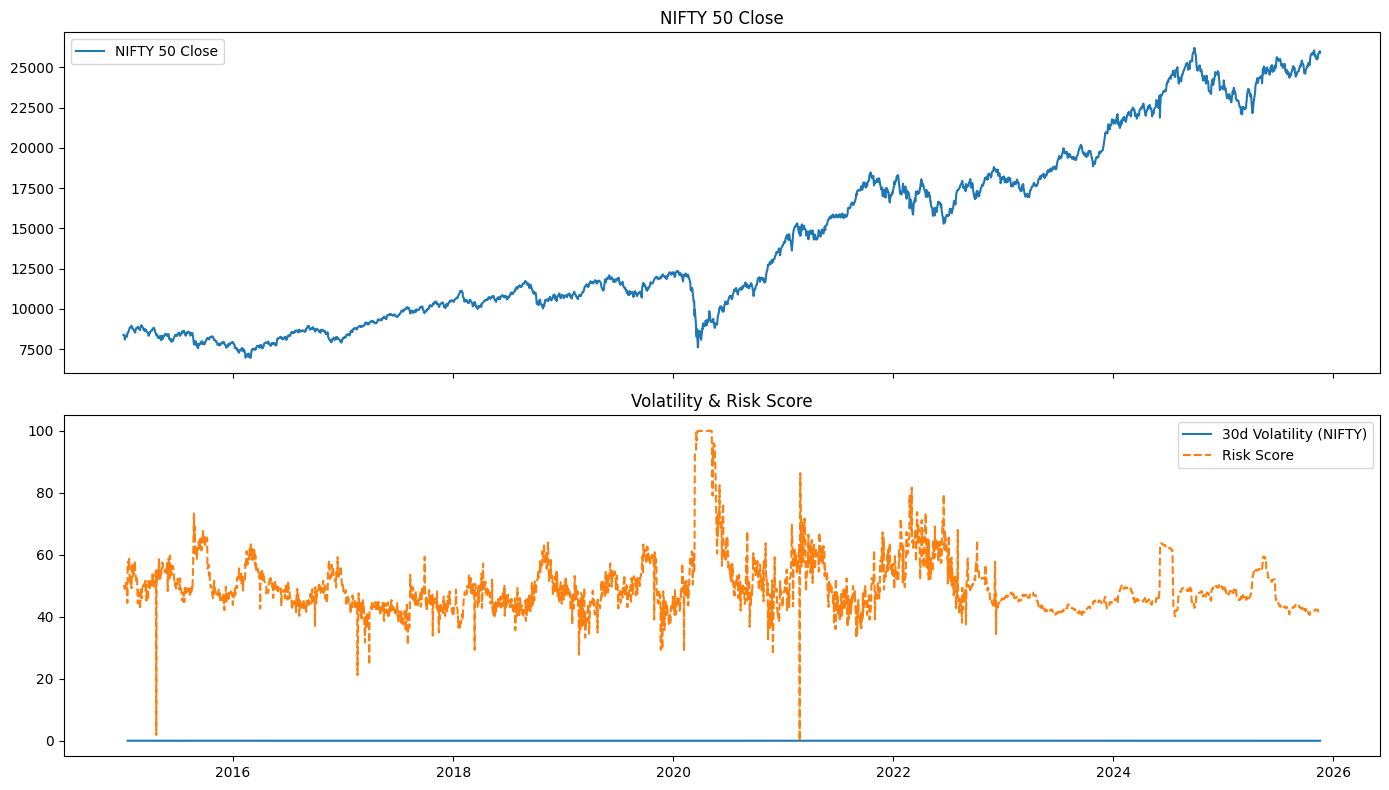

Saved master CSV to: master_market_data_2015_2022.csv
Saved cleaned FII/DII to: FII_DII_cleaned.csv


In [23]:
# Cell 8: quick plots and save final CSVs
fig, ax = plt.subplots(2,1, figsize=(14,8), sharex=True)
ax[0].plot(master['Date'], master['NIFTY_50_Close'], label='NIFTY 50 Close')
ax[0].set_title("NIFTY 50 Close")
ax[0].legend()
ax[1].plot(master['Date'], master['Vol_30d'], label='30d Volatility (NIFTY)')
ax[1].plot(master['Date'], master['Risk_Score'], label='Risk Score', linestyle='--')
ax[1].legend()
ax[1].set_title("Volatility & Risk Score")
plt.tight_layout()
plt.show()

# save final master CSV to /mnt/data
master.to_csv(MASTER_OUT, index=False)
print("Saved master CSV to:", MASTER_OUT)
# cleaned FII already saved earlier; re-save to same location for convenience
fii_clean.to_csv(CLEAN_FII_OUT, index=False)
print("Saved cleaned FII/DII to:", CLEAN_FII_OUT)
